Note: The scripts below provide illustrative steps for proximity calculations and the primary procedures used in multiple suitability analyses with Monte Carlo–based weighting.

# Preliminaries

In [7]:
arcpy.env.workspace = r'...\hawaii.gdb' # Locate the geodatabase (gdb) of the project

In [3]:
import arcpy

In [4]:
arcpy.env.overwriteOutput = True

# Calculate proximity to facilities
Notes: The script below shows an example of calculating distance to hospitals. We used the same parameter settings for all proximity calculations.
<br> We calculated raster-based distances using the Distance Accumulation tool. In these calculations, SLR and VE flood risk areas were treated as impassable barriers. Elevation was incorporated by calculating the hypotenuse of the horizontal cell distance and elevation change, and road inaccessibility was accounted for as a travel cost. Specifically, travel across areas without roads was modeled as ten times more difficult than travel along roads.

In [ ]:
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_HARN_UTM_Zone_4N",GEOGCS["GCS_North_American_1983_HARN",DATUM["D_North_American_1983_HARN",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-159.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]', scratchWorkspace=r"D:\GISprojects\Hawaii_Maui_fbd0a6\Hawaii_Maui_fbd0a6\p30\hawaii.gdb"):
    out_distance_accumulation_raster = arcpy.sa.DistanceAccumulation(
        in_source_data=r"Facilities\Hospitals (N=2)",
        in_barrier_data=r"SLR_and_Hazards\SLR_VE",
        in_surface_raster=r"Topology\Hawaii_elevation_MauiIsland",
        in_cost_raster=r"Facilities\Reclass_Road",
        in_vertical_raster=None,
        vertical_factor="BINARY 1 -30 30",
        in_horizontal_raster=None,
        horizontal_factor="BINARY 1 45",
        out_back_direction_raster=None,
        out_source_direction_raster=None,
        out_source_location_raster=None,
        source_initial_accumulation=None,
        source_maximum_accumulation=None,
        source_cost_multiplier=None,
        source_direction="",
        distance_method="GEODESIC"
    )
    out_distance_accumulation_raster.save(r"...\hawaii.gdb\Distance_hospital") # Locate the gdb for the output

# Suitability analysis: transforming data within each criterion
Note: This step follows the normalization of all suitability‐analysis criteria to a 1–10 scale. We manually transformed each criterion using the Suitability Modeler—for example, by assigning weights to discrete criteria and applying the MSSmall function to continuous criteria. The transformed outputs were generated in the Table of Contents but were not automatically added to the geodatabase, so we exported these raster outputs to the geodatabase using the scripts below.

In [ ]:
import os

# Set the output geodatabase (gdb)
export_gdb = r'D:\GISprojects\Maui\Maui\Maui\Hawaii_Maui\Hawaii_Maui_fbd0a6\p30\hawaii.gdb'

# Access the output transformed rasters in the memory and export them in the gdb
aprx = arcpy.mp.ArcGISProject("CURRENT")
map_obj = aprx.listMaps()[1]  # The SuitabilityAnalysis map is listed [1] in this project; this index may change if certain maps are deleted.

print("Accessed map successfully.")

# Loop through the created "Transformed_Data" group to access the transformed raster outputs.
# These outputs exist in the geodatabase but have been removed from the Table of Contents.
# To proceed, reviewers need to recreate a group in the Table of Contents that contains these transformed outputs.
for lyr in map_obj.listLayers():
    if lyr.name == "Transformed_Data" and lyr.isGroupLayer:
        print("Found 'Transformed_Data' group layer.")

        for sublayer in lyr.listLayers():
            # Clean and truncate name if needed
            out_name = sublayer.name.replace(" ", "_")[:60]  # GDB name limit: 63 characters
            out_path = os.path.join(export_gdb, out_name)

            print(f"Exporting: {sublayer.name} → {out_path}")
            
            try:
                arcpy.management.CopyRaster(sublayer, out_path)
                print(f"Exported: {out_name}")
            except Exception as e:
                print(f"Failed to export {sublayer.name}: {e}")
                continue

# Suitability analysis scenario #1: equal weighting all the criteria

In [ ]:
from arcpy.sa import Raster, Times, Plus, Con, IsNull

arcpy.CheckOutExtension("Spatial")

# Define working environment
arcpy.env.workspace = r"...\hawaii.gdb" # Locate the gdb
arcpy.env.snapRaster = "Transformed_Reclass_Slope"
arcpy.env.extent = "MAXOF"
arcpy.env.cellSize = "MINOF"

# Raw weights
weights_raw = [
    ("Transformed_Reclass_Slope", 1),
    ("Transformed_Flood_Raster", 1),
    ("Transformed_Burning_Probability", 1),
    ("Transformed_Distance_roads", 1),
    ("Transformed_Distance_Fire_Police", 1),
    ("Transformed_Distance_hospital", 1),
    ("Transformed_Distance_Food", 1),
    ("Transformed_Distance_gas", 1),
    ("Transformed_Distance_historicsites", 1),
    ("Transformed_Distance_parks", 1),
    ("Transformed_Distance_church", 1),
    ("Transformed_Distance_library", 1),
    ("Transformed_Distance_residential", 1),
    ("Transformed_Employment_density", 1)
]

# Normalize weights
total_weight = sum([w for _, w in weights_raw])
weighted_rasters = [(name, w / total_weight) for name, w in weights_raw]

# Step 1: Load and resample all rasters to a common snapRaster
weighted_layers = []
for raster_name, weight in weighted_rasters:
    print(f"Processing {raster_name} (weight {weight})")
    raster = Raster(raster_name)

    # Align via Con + Times (with fallback value 0 for NoData)
    cleaned = Con(IsNull(raster), 0, raster)
    weighted = Times(cleaned, weight)

    weighted_layers.append(weighted)

# Step 2: Add all weighted rasters
weighted_sum = weighted_layers[0]
for w in weighted_layers[1:]:
    weighted_sum = Plus(weighted_sum, w)


# Step 3: Save final result
weighted_sum.save("Suitability_equal_weighting")

print(f"Suitability_equal_weighting saved: {weighted_sum}")

## Display the suitability analysis results using equal weighting

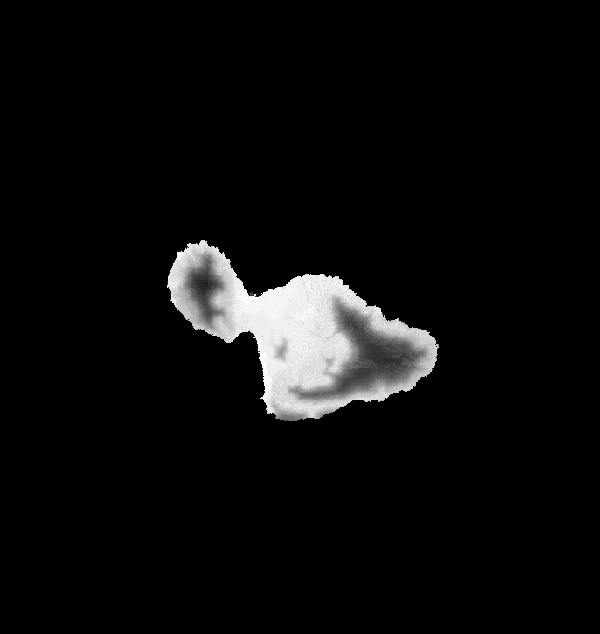

In [22]:
arcpy.Raster("Suitability_equal_weighting") 

# Suitability analysis scenario #2: hazard safety as the priority
Notes: We applied 50 Monte Carlo iterations to the criteria grouped by weighting category. In each iteration, weights were randomly drawn from the designated range for each raster layer and then normalized by dividing each sampled weight by the total sum, ensuring they collectively summed to one. Each raster layer was multiplied by its corresponding normalized weight, and the weighted layers were summed to generate a composite suitability surface for that iteration. The final suitability map was produced by averaging all composite surfaces.

In [10]:
import arcpy
from arcpy.sa import Raster, Times, Plus, Con, IsNull
import random

arcpy.CheckOutExtension("Spatial") 

# Define environment
arcpy.env.workspace = r"...\hawaii.gdb" # Locate the gdb
arcpy.env.snapRaster = "Transformed_Reclass_Slope"
arcpy.env.extent = "MAXOF"
arcpy.env.cellSize = "MINOF"

# Define weight ranges (min, max) for each layer
# Hazard safety as the priority
weights_range = {
    # High (0.7–1.0)
    "Transformed_Reclass_Slope": (0.7, 1.0),
    "Transformed_Flood_Raster": (0.7, 1.0),
    "Transformed_Burning_Probability": (0.7, 1.0),

    # Medium (0.4–0.7)
    "Transformed_Distance_roads": (0.4, 0.7),
    "Transformed_Distance_Fire_Police": (0.4, 0.7),
    "Transformed_Distance_hospital": (0.4, 0.7),
    "Transformed_Distance_gas": (0.4, 0.7),
    "Transformed_Distance_Food": (0.4, 0.7),

    # Low (0.1–0.4)
    "Transformed_Distance_residential": (0.1, 0.4),
    "Transformed_Employment_density": (0.1, 0.4),
    "Transformed_Distance_historicsites": (0.1, 0.4),
    "Transformed_Distance_library": (0.1, 0.4),
    "Transformed_Distance_church": (0.1, 0.4),
    "Transformed_Distance_parks": (0.1, 0.4)
}

# Monte Carlo setup
num_runs = 50
sum_raster = None

print("🔁 Running Monte Carlo suitability analysis...")

# Run the model 50 times
for run in range(num_runs):
    print(f"  ▶ Iteration {run+1}/{num_runs}")

    # Randomly sample weights from defined ranges
    sampled_weights = [(name, random.uniform(*weights_range[name])) for name in weights_range]
    total = sum(w for _, w in sampled_weights)
    normalized_weights = [(name, w / total) for name, w in sampled_weights]

    # Weighted overlay for this run
    weighted_sum = None
    for raster_name, weight in normalized_weights:
        raster = Raster(raster_name)
        cleaned = Con(IsNull(raster), 0, raster)
        weighted = Times(cleaned, weight)
        weighted_sum = weighted if weighted_sum is None else Plus(weighted_sum, weighted)

    # Accumulate the weighted sum
    sum_raster = weighted_sum if sum_raster is None else Plus(sum_raster, weighted_sum)

# Compute mean raster
mean_raster_hazard_safety_priority = Times(sum_raster, 1.0 / num_runs)

# Save the final result
output_path = r"...\hawaii.gdb\Hazard_Safety_Priority_MCMean" # Locate the gdb for the output
mean_raster_hazard_safety_priority.save(output_path)

print(f"✅ Monte Carlo mean suitability map saved to: {output_path}")

🔁 Running Monte Carlo suitability analysis...
  ▶ Iteration 1/50
  ▶ Iteration 2/50
  ▶ Iteration 3/50
  ▶ Iteration 4/50
  ▶ Iteration 5/50
  ▶ Iteration 6/50
  ▶ Iteration 7/50
  ▶ Iteration 8/50
  ▶ Iteration 9/50
  ▶ Iteration 10/50
  ▶ Iteration 11/50
  ▶ Iteration 12/50
  ▶ Iteration 13/50
  ▶ Iteration 14/50
  ▶ Iteration 15/50
  ▶ Iteration 16/50
  ▶ Iteration 17/50
  ▶ Iteration 18/50
  ▶ Iteration 19/50
  ▶ Iteration 20/50
  ▶ Iteration 21/50
  ▶ Iteration 22/50
  ▶ Iteration 23/50
  ▶ Iteration 24/50
  ▶ Iteration 25/50
  ▶ Iteration 26/50
  ▶ Iteration 27/50
  ▶ Iteration 28/50
  ▶ Iteration 29/50
  ▶ Iteration 30/50
  ▶ Iteration 31/50
  ▶ Iteration 32/50
  ▶ Iteration 33/50
  ▶ Iteration 34/50
  ▶ Iteration 35/50
  ▶ Iteration 36/50
  ▶ Iteration 37/50
  ▶ Iteration 38/50
  ▶ Iteration 39/50
  ▶ Iteration 40/50
  ▶ Iteration 41/50
  ▶ Iteration 42/50
  ▶ Iteration 43/50
  ▶ Iteration 44/50
  ▶ Iteration 45/50
  ▶ Iteration 46/50
  ▶ Iteration 47/50
  ▶ Iteration 48/50
  ▶

## Display the suitability analysis results with the hazard safety priority

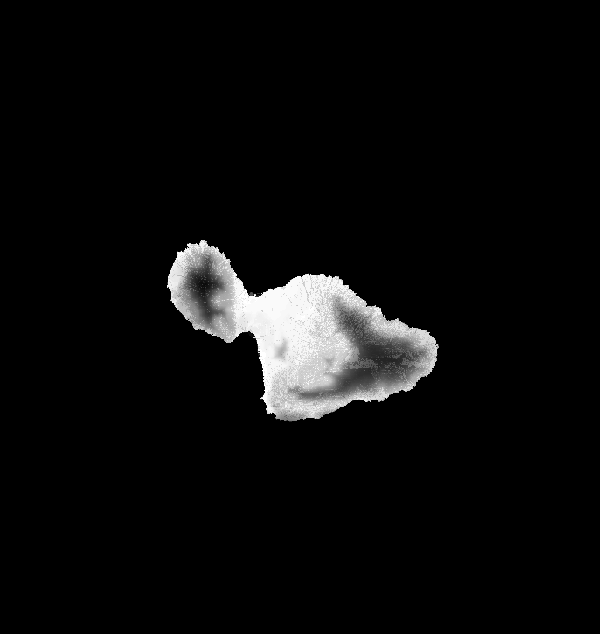

In [11]:
arcpy.Raster("mean_raster_hazard_safety") 

# Suitability analysis scenario #3: economic vitality as the priority

In [2]:
import arcpy
from arcpy.sa import Raster, Times, Plus, Con, IsNull
import random

arcpy.CheckOutExtension("Spatial")

# Define environment
arcpy.env.workspace = r"...\hawaii.gdb" # Locate the gdb
arcpy.env.snapRaster = "Transformed_Reclass_Slope"
arcpy.env.extent = "MAXOF"
arcpy.env.cellSize = "MINOF"

# Define weight ranges (min, max) for each layer
# Economic/tourism vitality as the priority
weights_range = {
    # High (0.7–1.0)
    "Transformed_Reclass_Slope": (0.7, 1.0),
    "Transformed_Employment_density": (0.7, 1.0),
    "Transformed_Distance_historicsites": (0.7, 1.0),
    "Transformed_Distance_parks": (0.7, 1.0),
    "Transformed_Distance_Food": (0.7, 1.0),
    "Transformed_Distance_roads": (0.7, 1.0),
    
    # Medium (0.4–0.7)
    "Transformed_Distance_gas": (0.4, 0.7),
    "Transformed_Distance_Fire_Police": (0.4, 0.7),
    "Transformed_Distance_hospital": (0.4, 0.7),  
    "Transformed_Flood_Raster": (0.4, 0.7),
    "Transformed_Burning_Probability": (0.4, 0.7), 

    # Low (0.2–0.5)
    "Transformed_Distance_residential": (0.1, 0.4),
    "Transformed_Distance_library": (0.1, 0.4),
    "Transformed_Distance_church": (0.1, 0.4),
    
}

# Monte Carlo setup
num_runs = 50
sum_raster = None

print("🔁 Running Monte Carlo suitability analysis...")

# Run the model 50 times
for run in range(num_runs):
    print(f"  ▶ Iteration {run+1}/{num_runs}")

    # Randomly sample weights from defined ranges
    sampled_weights = [(name, random.uniform(*weights_range[name])) for name in weights_range]
    total = sum(w for _, w in sampled_weights)
    normalized_weights = [(name, w / total) for name, w in sampled_weights]

    # Weighted overlay for this run
    weighted_sum = None
    for raster_name, weight in normalized_weights:
        raster = Raster(raster_name)
        cleaned = Con(IsNull(raster), 0, raster)
        weighted = Times(cleaned, weight)
        weighted_sum = weighted if weighted_sum is None else Plus(weighted_sum, weighted)

    # Accumulate the weighted sum
    sum_raster = weighted_sum if sum_raster is None else Plus(sum_raster, weighted_sum)

# Compute mean raster
mean_raster_economic_vitality_priority = Times(sum_raster, 1.0 / num_runs)

# Save the final result
output_path = r"...\hawaii.gdb\Economic_Vitality_Priority_MCMean" # Locate the gdb for the output
mean_raster_economic_vitality_priority.save(output_path)

print(f"✅ Monte Carlo mean suitability map saved to: {output_path}")

🔁 Running Monte Carlo suitability analysis...
  ▶ Iteration 1/50
  ▶ Iteration 2/50
  ▶ Iteration 3/50
  ▶ Iteration 4/50
  ▶ Iteration 5/50
  ▶ Iteration 6/50
  ▶ Iteration 7/50
  ▶ Iteration 8/50
  ▶ Iteration 9/50
  ▶ Iteration 10/50
  ▶ Iteration 11/50
  ▶ Iteration 12/50
  ▶ Iteration 13/50
  ▶ Iteration 14/50
  ▶ Iteration 15/50
  ▶ Iteration 16/50
  ▶ Iteration 17/50
  ▶ Iteration 18/50
  ▶ Iteration 19/50
  ▶ Iteration 20/50
  ▶ Iteration 21/50
  ▶ Iteration 22/50
  ▶ Iteration 23/50
  ▶ Iteration 24/50
  ▶ Iteration 25/50
  ▶ Iteration 26/50
  ▶ Iteration 27/50
  ▶ Iteration 28/50
  ▶ Iteration 29/50
  ▶ Iteration 30/50
  ▶ Iteration 31/50
  ▶ Iteration 32/50
  ▶ Iteration 33/50
  ▶ Iteration 34/50
  ▶ Iteration 35/50
  ▶ Iteration 36/50
  ▶ Iteration 37/50
  ▶ Iteration 38/50
  ▶ Iteration 39/50
  ▶ Iteration 40/50
  ▶ Iteration 41/50
  ▶ Iteration 42/50
  ▶ Iteration 43/50
  ▶ Iteration 44/50
  ▶ Iteration 45/50
  ▶ Iteration 46/50
  ▶ Iteration 47/50
  ▶ Iteration 48/50
  ▶

## Display the suitability analysis results with the economic vitality priority

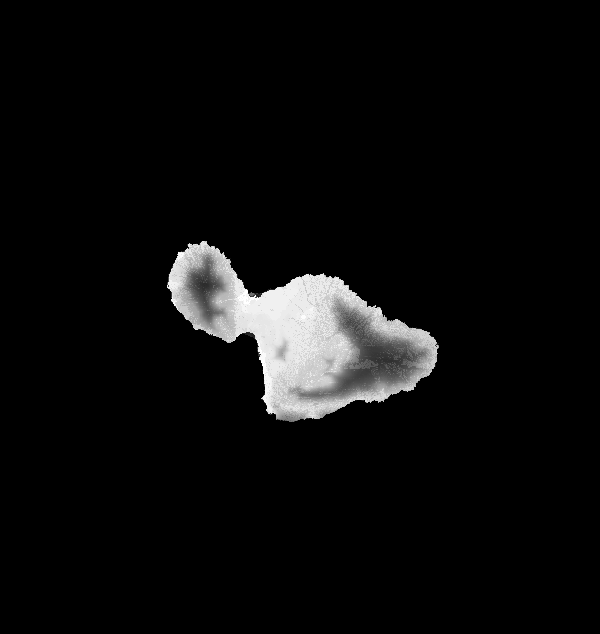

In [13]:
arcpy.Raster("mean_raster_economic_vitality")

# Suitability analysis scenario #4: community cohesion as the priority

In [ ]:
import arcpy
from arcpy.sa import Raster, Times, Plus, Con, IsNull
import random

arcpy.CheckOutExtension("Spatial")

# Define environment
arcpy.env.workspace = r"...\hawaii.gdb" # Locate the gdb
arcpy.env.snapRaster = "Transformed_Reclass_Slope"
arcpy.env.extent = "MAXOF"
arcpy.env.cellSize = "MINOF"

# Define weight ranges (min, max) for each layer
# Community cohesion as the priority
weights_range = {
    # High (0.7–1.0)
    "Transformed_Reclass_Slope": (0.7, 1.0),
    "Transformed_Distance_residential": (0.7, 1.0),
    "Transformed_Distance_historicsites": (0.7, 1.0),
    "Transformed_Distance_parks": (0.7, 1.0),
    "Transformed_Distance_library": (0.7, 1.0),
    "Transformed_Distance_church": (0.7, 1.0),
 
    # Medium (0.4–0.7)
    "Transformed_Distance_roads": (0.4, 0.7),
    "Transformed_Distance_Fire_Police": (0.4, 0.7),
    "Transformed_Distance_hospital": (0.4, 0.7),  
    "Transformed_Distance_Food": (0.4, 0.7),
    "Transformed_Distance_gas": (0.1, 0.4),

    # Low (0.2–0.5)
    "Transformed_Employment_density": (0.1, 0.4),
    "Transformed_Flood_Raster": (0.1, 0.4),
    "Transformed_Burning_Probability": (0.1, 0.4)
}

# Monte Carlo setup
num_runs = 50
sum_raster = None

print("🔁 Running Monte Carlo suitability analysis...")

# Run the model 50 times
for run in range(num_runs):
    print(f"  ▶ Iteration {run+1}/{num_runs}")

    # Randomly sample weights from defined ranges
    sampled_weights = [(name, random.uniform(*weights_range[name])) for name in weights_range]
    total = sum(w for _, w in sampled_weights)
    normalized_weights = [(name, w / total) for name, w in sampled_weights]

    # Weighted overlay for this run
    weighted_sum = None
    for raster_name, weight in normalized_weights:
        raster = Raster(raster_name)
        cleaned = Con(IsNull(raster), 0, raster)
        weighted = Times(cleaned, weight)
        weighted_sum = weighted if weighted_sum is None else Plus(weighted_sum, weighted)

    # Accumulate the weighted sum
    sum_raster = weighted_sum if sum_raster is None else Plus(sum_raster, weighted_sum)

# Compute mean raster
mean_raster_community_cohesion_priority = Times(sum_raster, 1.0 / num_runs)

# Save the final result
output_path = r"...\hawaii.gdb\Community_Cohesion_Priority_MCMean" # Locate the gdb for the output
mean_raster_community_cohesion_priority.save(output_path)

print(f"✅ Monte Carlo mean suitability map saved to: {output_path}")

🔁 Running Monte Carlo suitability analysis...
  ▶ Iteration 1/50
  ▶ Iteration 2/50
  ▶ Iteration 3/50
  ▶ Iteration 4/50
  ▶ Iteration 5/50
  ▶ Iteration 6/50
  ▶ Iteration 7/50
  ▶ Iteration 8/50
  ▶ Iteration 9/50
  ▶ Iteration 10/50
  ▶ Iteration 11/50
  ▶ Iteration 12/50
  ▶ Iteration 13/50
  ▶ Iteration 14/50
  ▶ Iteration 15/50
  ▶ Iteration 16/50
  ▶ Iteration 17/50
  ▶ Iteration 18/50
  ▶ Iteration 19/50
  ▶ Iteration 20/50
  ▶ Iteration 21/50
  ▶ Iteration 22/50
  ▶ Iteration 23/50
  ▶ Iteration 24/50
  ▶ Iteration 25/50
  ▶ Iteration 26/50
  ▶ Iteration 27/50
  ▶ Iteration 28/50
  ▶ Iteration 29/50
  ▶ Iteration 30/50
  ▶ Iteration 31/50
  ▶ Iteration 32/50
  ▶ Iteration 33/50
  ▶ Iteration 34/50
  ▶ Iteration 35/50
  ▶ Iteration 36/50
  ▶ Iteration 37/50
  ▶ Iteration 38/50
  ▶ Iteration 39/50
  ▶ Iteration 40/50
  ▶ Iteration 41/50
  ▶ Iteration 42/50
  ▶ Iteration 43/50
  ▶ Iteration 44/50
  ▶ Iteration 45/50
  ▶ Iteration 46/50
  ▶ Iteration 47/50
  ▶ Iteration 48/50
  ▶

## Display the suitability analysis results with the community cohesion priority

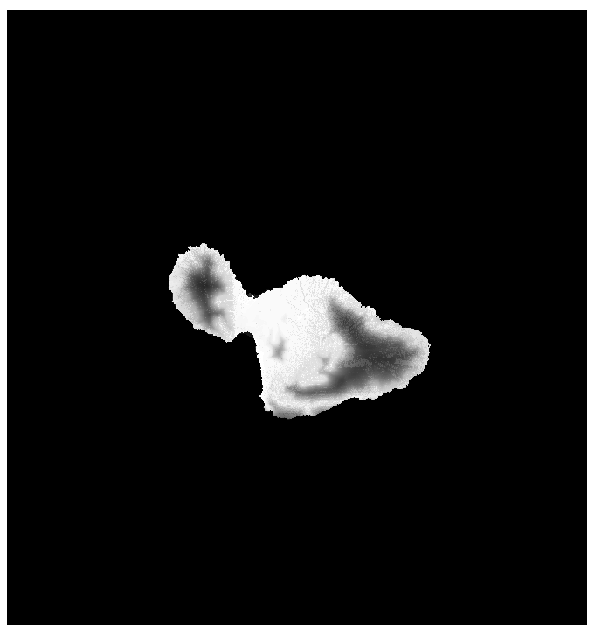

In [19]:
arcpy.Raster("mean_raster_community_cohesion")

# Clip the raster to the Maui Island boundary
Notes: we clipped all the raster outputs to the Maui Island boundary.

In [ ]:
arcpy.management.Clip(
    in_raster="Economic_Vitality_Priority_MCMean",
    rectangle="739523.0048 2277309.3507 814548.5659 2327490.5691",
    out_raster=r"...\hawaii.gdb\mean_raster_economic_Maui", # Locate the gdb
    in_template_dataset="Maui_island_boundary",
    nodata_value="3.4e+38",
    clipping_geometry="ClippingGeometry",
    maintain_clipping_extent="NO_MAINTAIN_EXTENT"
)

# Exclude non-suitable areas (SLR, flood VE area, wetlands, reserves, and critical habitats)
Notes: SLR and Flood VE areas were excluded during proximity calculations. We now only need to further exclude steep-slope and ecologically sensitive areas.

## Exclude areas with slope > 35%

In [7]:
with arcpy.EnvManager(scratchWorkspace=r"...\hawaii.gdb"): # Locate the gdb
    out_raster = arcpy.sa.ExtractByMask(
        in_raster="mean_raster_economic_Maui",
        in_mask_data="Slope_excludeNonFit",
        extraction_area="INSIDE",
        analysis_extent='739500.348515924 2277309.58758541 814549.277109869 2327492.7259593 PROJCS["NAD_1983_HARN_UTM_Zone_4N",GEOGCS["GCS_North_American_1983_HARN",DATUM["D_North_American_1983_HARN",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-159.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
    )
    out_raster.save(r"...\hawaii.gdb\EV_excludeSlope") # Locate the gdb for the output

## Exclude areas with ecologically sensitive areas

In [8]:
with arcpy.EnvManager(scratchWorkspace=r"...\hawaii.gdb"): # Locate the gdb
    out_raster = arcpy.sa.ExtractByMask(
        in_raster="EV_excludeSlope",
        in_mask_data="Exclude_nonfit_relocation",
        extraction_area="INSIDE",
        analysis_extent='739560.8854 2277475.7066 814541.9515 2327488.904 PROJCS["NAD_1983_HARN_UTM_Zone_4N",GEOGCS["GCS_North_American_1983_HARN",DATUM["D_North_American_1983_HARN",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-159.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
    )
    out_raster.save(r"...\hawaii.gdb\EV_excludeNonfit") # Locate the gdb for the output

# Suitability analysis scenario #5: averaged results across the three prioritized scenarios and a standard deviation map

In [1]:
from arcpy.sa import Raster, Plus, Divide, SquareRoot, Power

# Load your rasters
r1 = Raster("Priority of Hazard Safety")
r2 = Raster("Priority of Economic Vitality")
r3 = Raster("Priority of Community Cohesion")

# Mean raster
mean = (r1 + r2 + r3) / 3

# SD calculation
sd = SquareRoot(((Power(r1 - mean, 2) + Power(r2 - mean, 2) + Power(r3 - mean, 2)) / 3))
sd.save("Suitability_SD")

# Select high-suitability, high-stability (low-SD) areas

In [11]:
import arcpy
from arcpy.sa import Raster, Con

arcpy.CheckOutExtension("Spatial")

# Load rasters
mean_raster = Raster("Combined_three_priorities")      # Replace with your actual raster name
sd_raster = Raster("Suitability_SD")          # Replace with your actual raster name

# Define the threshold: Mean > 0.9 and SD < 0.25
suitability_zone = Con((mean_raster > 0.9) & (sd_raster < 0.25), 1)

# Save output
suitability_zone.save("High_suitability_low_SD")

print(f"✔ Saved selected suitability zone to the gdb")

✔ Saved selected suitability zone to the gdb
